#  About the Author

**👤 Name:** Muhammad Umer  
**🔗 LinkedIn:** [https://www.linkedin.com/in/therealumerhayat/](https://www.linkedin.com/in/therealumerhayat/)  
**📧 Gmail:** umerhayat282@gmail.com  
**📞 Contact Number:** +92 302 9854427 / +92 317 6239577

### 📌 Project Note

> **Note:** This project is a collaborative effort completed during the course of study at [WorldQuant University](https://www.wqu.edu/).


****

### 🩺 Project Overview: Detecting Abnormalities in Mammogram Images with Deep Learning

Medical image analysis typically requires expert radiologists to carefully examine scans for abnormalities. This process is not only time-consuming but also costly due to the need for specialized knowledge. With the rapid development of deep learning, there is growing interest in automating medical image interpretation using neural networks.

In this project, we focus on building a neural network that can **identify potential cancerous regions in mammogram images**. However, due to the limited availability of annotated mammogram datasets, we utilize **Medigan**, a model library that includes medical image generators, to create synthetic mammogram images along with corresponding segmentation masks that highlight suspicious areas.

We then use this synthetic dataset to train a convolutional neural network to learn how to detect these abnormalities. This project showcases how generative models and deep learning can be combined to tackle real-world challenges in medical diagnostics, especially when access to large medical datasets is limited.



> This work demonstrates practical application of machine learning techniques in healthcare, and serves as a foundational step towards more automated, scalable diagnostic systems.


****

# 1. Importing required liabraries

In [3]:
from pathlib import Path
import medigan
import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

# 2. Checking if GPU is available

In [4]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using {device} device")

Using cuda device


# 3. Find medigan that produces mammogram images with region of interest marked

In [5]:
generators = medigan.Generators()
generators

Generators(model_ids=['00001_DCGAN_MMG_CALC_ROI', '00002_DCGAN_MMG_MASS_ROI', '00003_CYCLEGAN_MMG_DENSITY_FULL', '00004_PIX2PIX_MMG_MASSES_W_MASKS', '00005_DCGAN_MMG_MASS_ROI', '00006_WGANGP_MMG_MASS_ROI', '00007_INPAINT_BRAIN_MRI', '00008_C-DCGAN_MMG_MASSES', '00009_PGGAN_POLYP_PATCHES_W_MASKS', '00010_FASTGAN_POLYP_PATCHES_W_MASKS', '00011_SINGAN_POLYP_PATCHES_W_MASKS', '00012_C-DCGAN_MMG_MASSES', '00013_CYCLEGAN_MMG_DENSITY_OPTIMAM_MLO', '00014_CYCLEGAN_MMG_DENSITY_OPTIMAM_CC', '00015_CYCLEGAN_MMG_DENSITY_CSAW_MLO', '00016_CYCLEGAN_MMG_DENSITY_CSAW_CC', '00017_DCGAN_XRAY_LUNG_NODULES', '00018_WGANGP_XRAY_LUNG_NODULES', '00019_PGGAN_CHEST_XRAY', '00020_PGGAN_CHEST_XRAY', '00021_CYCLEGAN_BRAIN_MRI_T1_T2', '00022_WGAN_CARDIAC_AGING', '00023_PIX2PIXHD_BREAST_DCEMRI'], model_executors=[], model_selector: ModelSelector(model_ids=['00001_DCGAN_MMG_CALC_ROI', '00002_DCGAN_MMG_MASS_ROI', '00003_CYCLEGAN_MMG_DENSITY_FULL', '00004_PIX2PIX_MMG_MASSES_W_MASKS', '00005_DCGAN_MMG_MASS_ROI', '00006

In [7]:
values_to_search = ['mammogram', 'roi']
models = generators.find_matching_models_by_values(values_to_search)
models

[ModelMatchCandidate(model_id=00004_PIX2PIX_MMG_MASSES_W_MASKS, is_match=True, operator: AND, target_values=['mammogram', 'roi'])]

In [8]:
model_id = models[0].model_id
model_id

'00004_PIX2PIX_MMG_MASSES_W_MASKS'

# 4. Get the model configuration that i found

In [9]:
config_model = generators.get_config_by_id(model_id=model_id)
print(f"Model Keys: {config_model.keys()}")

Model Keys: dict_keys(['execution', 'selection', 'description'])


# 5. Select Predefined keys from model config

In [10]:
val_to_select = ["generates", "tags", "height", "width"]
model_inf = {x: config_model['selection'][x] for x in val_to_select}
model_inf

{'generates': ['regions of interest',
  'ROI',
  'mammograms',
  'patches',
  'full-field digital mammograms'],
 'tags': ['Mammogram',
  'Mammography',
  'Digital Mammography',
  'Full field Mammography',
  'Full-field Mammography',
  'pix2pix',
  'Pix2Pix',
  'Mass segmentation',
  'Breast lesion'],
 'height': 256,
 'width': 256}

# 6. Creating path directory using pathlib

In [11]:
output_directory = Path("output")
sample_directory = output_directory / "mammogram_sample"
sample_directory.mkdir(parents=True, exist_ok=True)
print(sample_directory)

output/mammogram_sample


# 7. Generate images and region of interest using out selected GAN and save the images in our directory

In [16]:
generators.generate(
    model_id=model_id,
    num_samples=4,
    output_path=sample_directory,
    install_dependencies=True
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 MB 31.8 MB/s eta 0:00:00


100%|██████████| 1/1 [00:06<00:00,  6.22s/it]


# 8. Creating the function that will pick the images from the directory and visualize

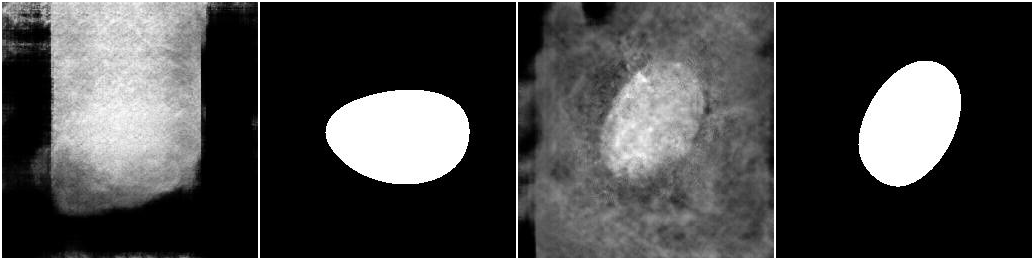

In [18]:
def image_view(directory, num_images=4, glob_rule="*.jpg"):
    image_list = list(directory.glob(glob_rule))
    number_sample = min(num_images, len(image_list))
    images = [read_image(str(f)) for f in sorted(image_list)[:number_sample]]
    grid = make_grid(images, nrow=4, pad_value=255.0)
    return torchvision.transforms.ToPILImage()(grid)


sample_images = image_view(sample_directory)
sample_images

# 9. Using medigan to genrate training data images dataloader with batch_size 

In [19]:
train_loader = generators.get_as_torch_dataloader(
    model_id=model_id, num_samples=50, batch_size=4, shuffle=True, prefetch_factor=None
)
sample_batch = next(iter(train_loader))
print(f"Training data loader with keys: {sample_batch.keys()}")

Training data loader with keys: dict_keys(['sample', 'mask'])


# 10. Creating validation dataloader 

In [20]:
val_loader = generators.get_as_torch_dataloader(
    model_id=model_id, num_samples=30, batch_size=4, shuffle=False, prefetch_factor=None
)
val_batch = next(iter(train_loader))
shape = val_batch['sample'].shape
dtype = val_batch['sample'].dtype
print(f"Validation image with data shape {shape} and type {dtype}")

Validation image with data shape torch.Size([4, 256, 256]) and type torch.float32


# 11. Checking the shape

In [21]:
shape = val_batch['mask'].shape
dtype = val_batch['mask'].dtype
print(f"Validation mask with data shape {shape} and type {dtype}.")

Validation mask with data shape torch.Size([4, 256, 256]) and type torch.uint8.


In [22]:
#defining function the will convert the tensor to torch image
def convert_to_timage(tensor, color=False):
    t_float = tensor.type(torch.float32)
    grayscale = t_float.unsqueeze(1)
    if color:
        return grayscale.repeat(1,3,1,1)
    else:
        return grayscale

# 12. Reshapeing the mask of validation batch to check

In [23]:
mask_conv = convert_to_timage(val_batch['mask'])
shape = mask_conv.shape
dtype = mask_conv.dtype
print(f"Validation mask with data shape {shape} and tpe {dtype}")

Validation mask with data shape torch.Size([4, 1, 256, 256]) and tpe torch.float32


# 13. Reshaping the images of validation batch

In [24]:
sample_conv = convert_to_timage(val_batch['sample'], color=True)
shape = sample_conv.shape
dtype = sample_conv.dtype
print(f"Validation mask with data shape {shape} and type {dtype}")

Validation mask with data shape torch.Size([4, 3, 256, 256]) and type torch.float32


# 14. Load Pretrained model deeplabv3_resnet50 with COCO_WITH_VOC_LABELS_V1 pretrained weights

In [43]:
pretrained_weights = (
    torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
)
model = torchvision.models.segmentation.deeplabv3_resnet50(weights=pretrained_weights)

In [44]:
print("Model Components")
for name, part in model.named_children():
    print("\t" + name)

Model Components
	backbone
	classifier
	aux_classifier


# 15. Run the model on images of the sample batch to check what type of shape its returning

In [45]:
samp_converted = convert_to_timage(sample_batch['sample'], True)
model_result = model(samp_converted)
model_out = model_result['out']
out_shape = model_out.shape
out_shape

torch.Size([4, 21, 256, 256])

> Shape is not as we assume so lets check the last output layer of the model and change it

In [46]:
model.classifier[-1]

Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))

# 16. Replace the last layer to get the desired output

In [47]:
new_final_layer_shape = torch.nn.Conv2d(256, 1, kernel_size=(1,1))
model.classifier[-1] = new_final_layer_shape
new_out = model(samp_converted)['out']
print(f"Final Model Ouput shape: {new_out.shape}")
print(f"Mask Shape: {mask_conv.shape}")

Final Model Ouput shape: torch.Size([4, 1, 256, 256])
Mask Shape: torch.Size([4, 1, 256, 256])


# 17. Create the loss function and optimizer

In [48]:
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

# 18. Defining function the will compute the loss

In [49]:
def compute_loss(batch, model, loss_function):
    sample = batch['sample']
    mask = batch['mask']
    sample_corrected = convert_to_timage(sample, color=True)
    mask_corrected = convert_to_timage(mask)
    sample_gpu = sample_corrected.to(device)
    mask_gpu = mask_corrected.to(device)
    output = model(sample_gpu)['out']
    loss = loss_function(output, mask_gpu)
    return loss

In [50]:
model.to(device)
compute_loss(sample_batch, model, loss_function)

tensor(0.8002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

# 19. Defining the the training function

In [51]:
def training_epochs(model, train_loader, val_loader, loss_function, optimizer):
    model.train()
    
    training_loss = 0.0
    training_count = 0 
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        loss = compute_loss(batch, model, loss_function)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        training_count += 1

    validation_loss = 0.0
    validation_count = 0
    for batch in tqdm(val_loader):
        loss = compute_loss(batch, model, loss_function)
        validation_loss += loss.item()
        validation_count += 1

    
    return training_loss / training_count, validation_loss / validation_count

In [52]:
train_history = []
val_history = []

num_epoch = 8
for epoch in range(num_epoch):
    training_loss, validation_loss = training_epochs(model, train_loader, val_loader,loss_function, optimizer)
    train_history.append(training_loss)
    val_history.append(validation_loss)
    print(f"Epoch {epoch+1}: Train Loss = {training_loss:.4f}, Validation Loss = {validation_loss:.4f}")

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4286, Validation Loss = 0.2534


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.1919, Validation Loss = 0.1889


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.1300, Validation Loss = 0.1446


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.1069, Validation Loss = 0.1411


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.0880, Validation Loss = 0.1133


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6: Train Loss = 0.0656, Validation Loss = 0.1068


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7: Train Loss = 0.0638, Validation Loss = 0.1197


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8: Train Loss = 0.0611, Validation Loss = 0.1111


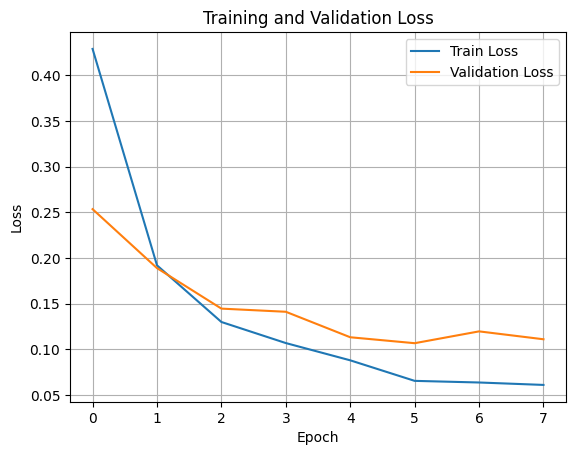

In [53]:
import matplotlib.pyplot as plt

plt.plot(train_history, label='Train Loss')
plt.plot(val_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


# 20. Set Model to Evaluation mode

In [54]:
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

# 21. Using Medigan to generate dataloader of test data

In [55]:
test_loader = generators.get_as_torch_dataloader(
    model_id=model_id, num_samples=8, batch_size=4, shuffle=False, prefetch_factor=None
)
test_batch = next(iter(test_loader))
print(f"Data Loader images in batches of {test_batch['sample'].size(0)}")

Data Loader images in batches of 4


# 22. Rehshape and move data to GPU and test model

In [56]:
corrected_sample = convert_to_timage(test_batch['sample'], color=True)
corrected_sample = corrected_sample.to(device)
test_result = model(corrected_sample)['out']
test_result.shape

torch.Size([4, 1, 256, 256])

# 23. Apply Sigmoid function to the test result 

In [57]:
test_model_mask = torch.sigmoid(test_result)

In [58]:
def plot_images_from_tensor(tensor):
    grid = make_grid(tensor, nrow=4, pad_value=1.0)
    return torchvision.transforms.ToPILImage()(grid)

# 24. Call Plot function that we created above and see final result

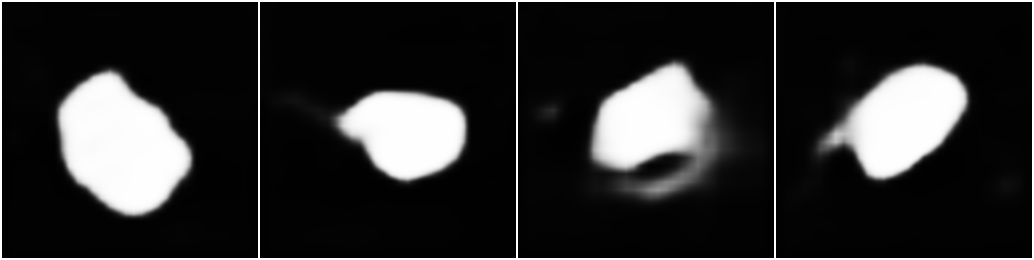

In [59]:
sample_test_batch_plot = plot_images_from_tensor(convert_to_timage(test_batch['sample']))
sample_test_batch_plot
mask_test_batch_plot = plot_images_from_tensor(convert_to_timage(test_batch['mask']))
mask_test_batch_plot
model_result = plot_images_from_tensor(test_model_mask)
model_result

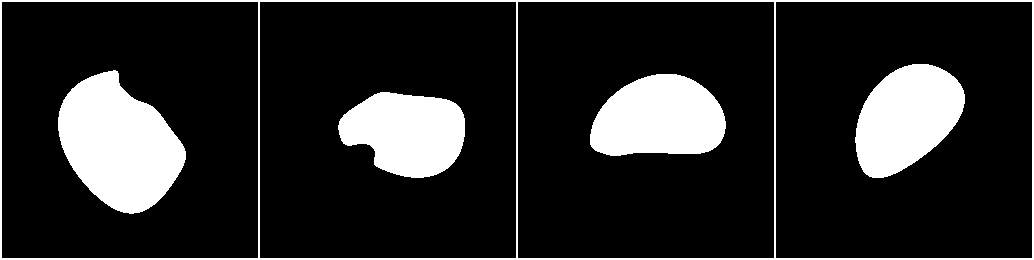

In [61]:
mask_test_batch_plot = plot_images_from_tensor(convert_to_timage(test_batch['mask']))
mask_test_batch_plot

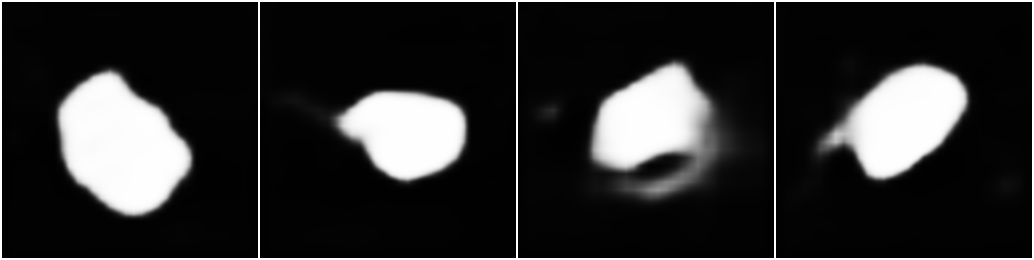

In [63]:
model_result_plot = plot_images_from_tensor(test_model_mask)
model_result_plot